In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def target_density(x):
    """
    Unnormalized target density for the Metropolis algorithm.

    In this example, the target distribution is a standard normal distribution:
        p(x) =~ exp(-0.5 * x^2)

    Parameters
    ----------
    x : float or ndarray
        Point(s) at which to evaluate the unnormalized density.

    Returns
    -------
    float or ndarray
        Value(s) of the unnormalized density at x.
    """
    return np.exp(-0.5 * x**2)


def metropolis_step(p, x, proposal_std):
    """
    Perform one Metropolis step for a single Markov chain.

    Steps:
    1. Generate a proposal state by adding Gaussian noise to the current state.
    2. Compute the acceptance probability alpha = min(1, p(x_proposed)/p(x_current)).
    3. Draw u ~ Uniform(0,1). Accept the proposal if u < alpha; otherwise, keep current state.

    Parameters
    ----------
    p : callable
        Function proportional to the target density p(x). Can be unnormalized.
    x : float
        Current state of the Markov chain.
    proposal_std : float
        Standard deviation of the Gaussian proposal distribution.

    Returns
    -------
    x_new : float
        Next state of the Markov chain after this Metropolis step.
    """
    # propose a new state using Gaussian random walk
    x_hat = x + np.random.randn() * proposal_std

    # compute acceptance probability
    alpha = min(1, p(x_hat) / p(x))

    # accept or reject the proposal
    u = np.random.uniform(0, 1)  
    if u < alpha:
        x = x_hat # accept

    return x

def metropolis_n_dim(p, x0, n_samples, proposal_std=1.0, seed=None):
    """
    Metropolis algorithm for sampling from a target distribution p(x).

    Parameters
    ----------
    p : callable
        Target density function proportional to p(x). 
        It should accept a NumPy array and return a scalar.
    x0 : array_like
        Initial state (1D NumPy array or scalar).
    n_samples : int
        Number of samples to generate.
    proposal_std : float, optional
        Standard deviation of the Gaussian proposal distribution N(0, proposal_std^2 I).
    seed : int, optional
        Random seed for reproducibility.

    Returns
    -------
    samples : ndarray
        Generated samples of shape (n_samples, d).
    acceptance_rate : float
        Fraction of proposed samples that were accepted.
    """
    if seed is not None:
        np.random.seed(seed)
    
    x = np.array(x0, dtype=float)
    d = x.size if x.ndim > 0 else 1
    samples = np.zeros((n_samples, d))
    n_accept = 0

    for i in range(n_samples):
        # Step 1: Propose a new candidate
        eps = np.random.randn(d) * proposal_std
        x_hat = x + eps

        # Step 2: Compute acceptance ratio
        u = np.random.rand()
        accept_prob = min(1.0, p(x_hat) / p(x))

        # Step 3: Accept or reject
        if u < accept_prob:
            x = x_hat
            n_accept += 1

        samples[i] = x

    acceptance_rate = n_accept / n_samples
    return samples, acceptance_rate


# 2D target distribution: standard normal
def target_density(theta):
    return np.exp(-0.5 * np.sum(theta**2))



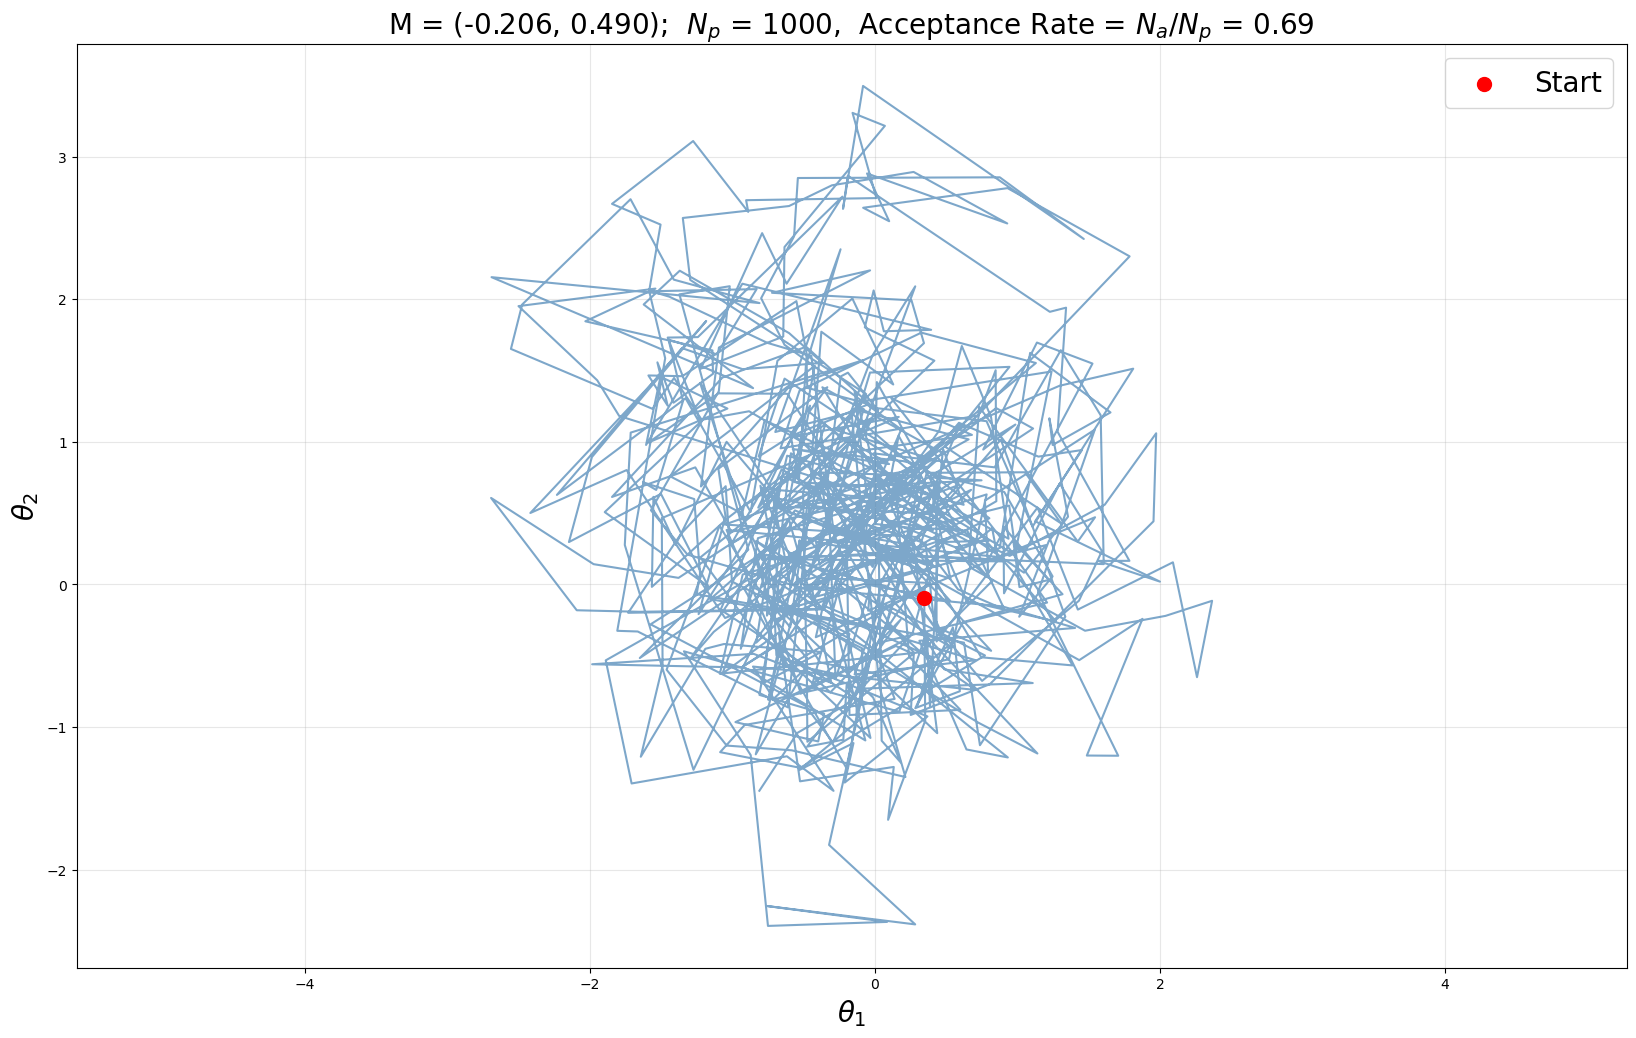

In [3]:
# Run simulation
samples, acc_rate = metropolis_n_dim(target_density, [0, 0], 1000, proposal_std=0.7, seed=42)
mean_est = np.mean(samples, axis=0)

# Plot trajectory
plt.figure(figsize=(20, 12))
plt.plot(samples[:,0], samples[:,1], alpha=0.7, color='steelblue')
plt.scatter(samples[0,0], samples[0,1], color='red', label='Start', zorder=5, s=100)
plt.title(f"M = ({mean_est[0]:.3f}, {mean_est[1]:.3f});  " f"$N_p$ = {len(samples)},  Acceptance Rate = $N_a/N_p$ = {acc_rate:.2f}", fontsize=20)
plt.xlabel(r"$\theta_1$", fontsize=20)
plt.ylabel(r"$\theta_2$", fontsize=20)
plt.legend(fontsize=20)
plt.axis('equal')
plt.grid(alpha=0.3)
plt.show()


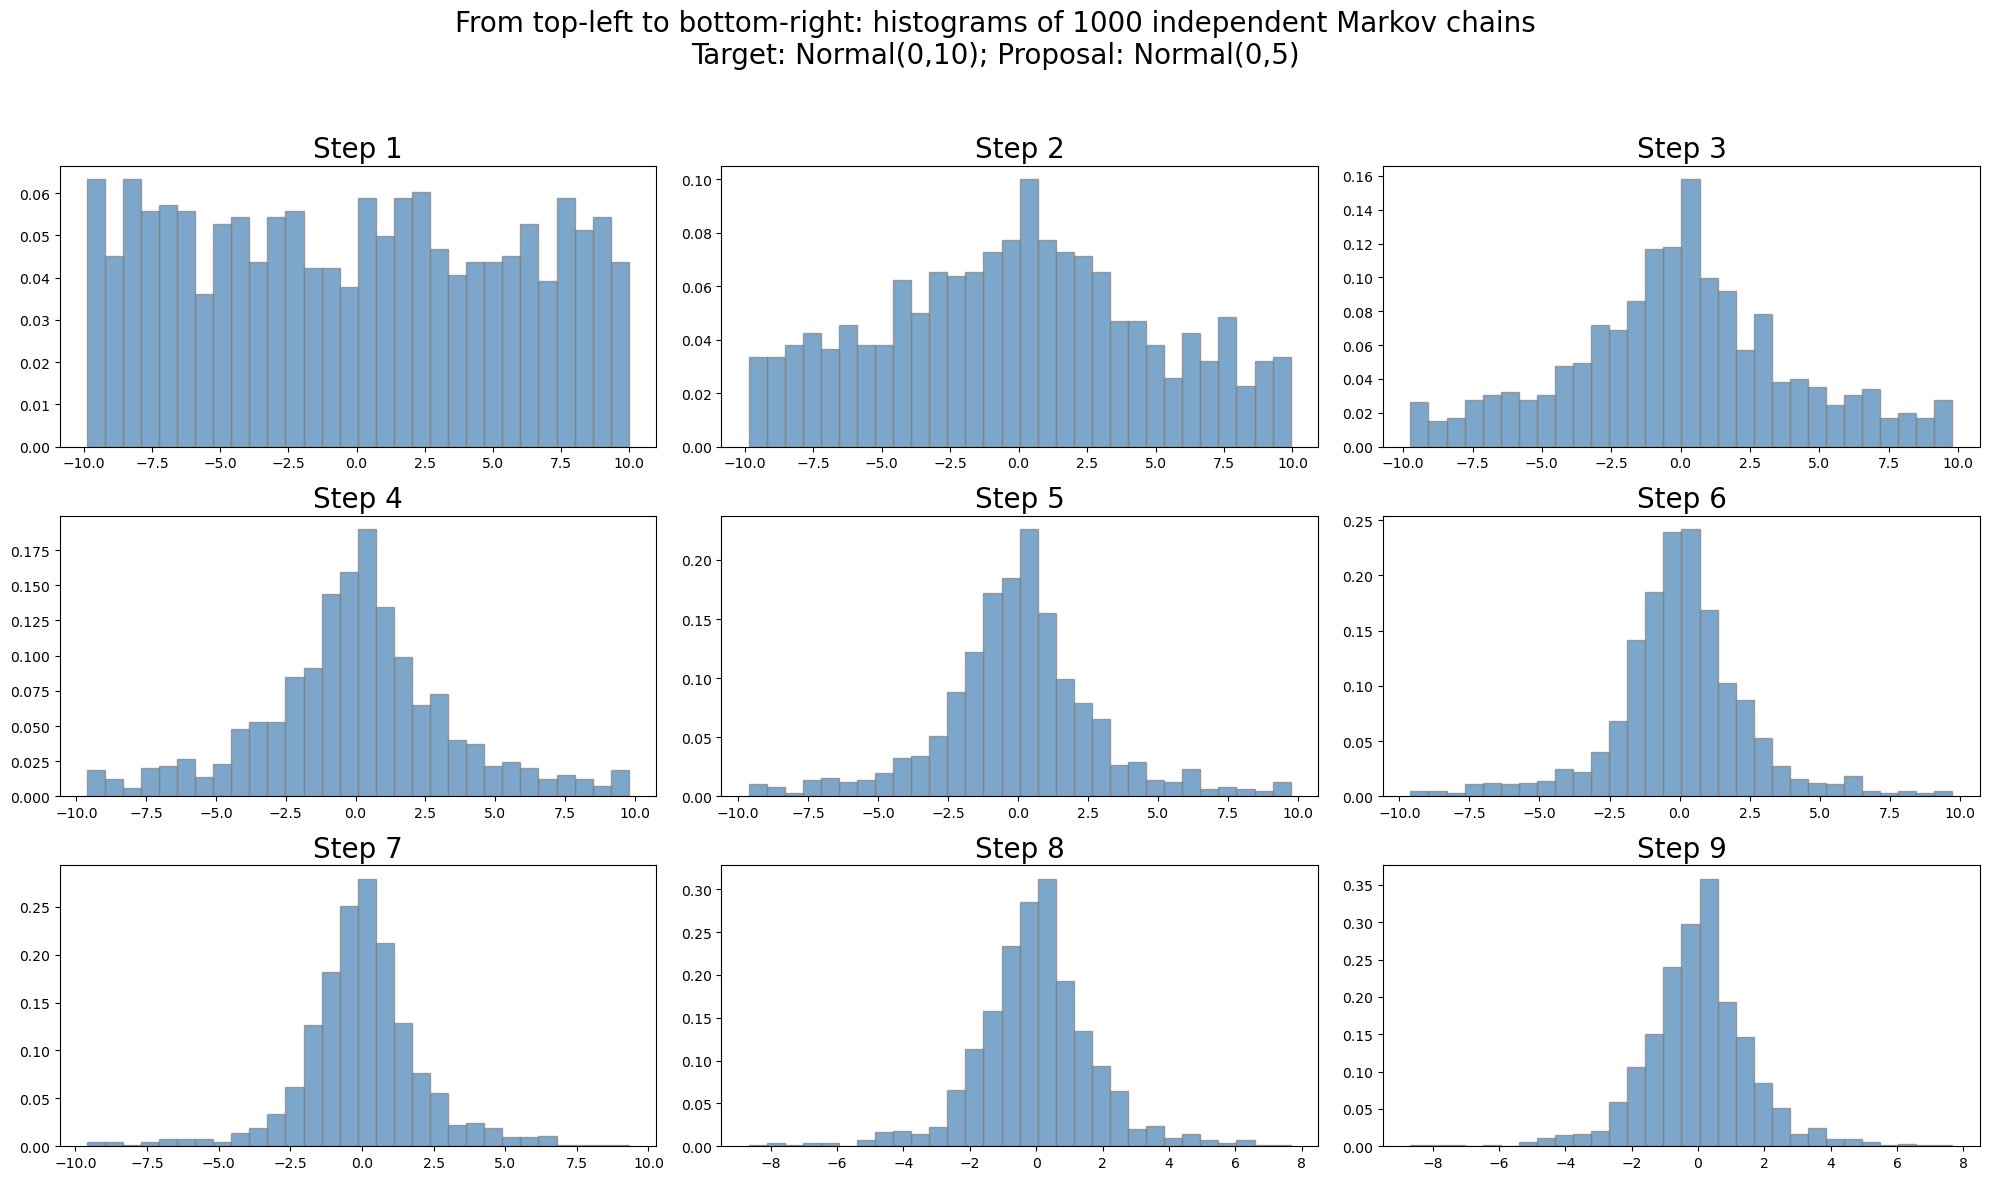

In [4]:
# simulation parameters
np.random.seed(42)     # reproducibility
n_chains = 1000        # number of independent chains
n_steps = 9            # number of snapshots (histograms)
proposal_std = 5       # standard deviation of proposal (smaller for better acceptance)

# initialize all chains uniformly between -10 and +10
x = np.random.uniform(-10, 10, size=n_chains)

# run Metropolis algorithm
snapshots = []

for t in range(n_steps):
    snapshots.append(x.copy())  # store current states for plotting
    # update all chains by one Metropolis step
    for i in range(n_chains):
        x[i] = metropolis_step(target_density, x[i], proposal_std)

# plot histograms
fig, axes = plt.subplots(3, 3, figsize=(20, 12))
axes = axes.ravel()
for i, x_snapshot in enumerate(snapshots):
    axes[i].hist(x_snapshot, bins=30, density=True, 
                 color='steelblue', alpha=0.7, edgecolor='gray')
    axes[i].set_title(f"Step {i+1}", fontsize=20)
plt.suptitle(
    "From top-left to bottom-right: histograms of 1000 independent Markov chains\n"
    "Target: Normal(0,10); Proposal: Normal(0,5)", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


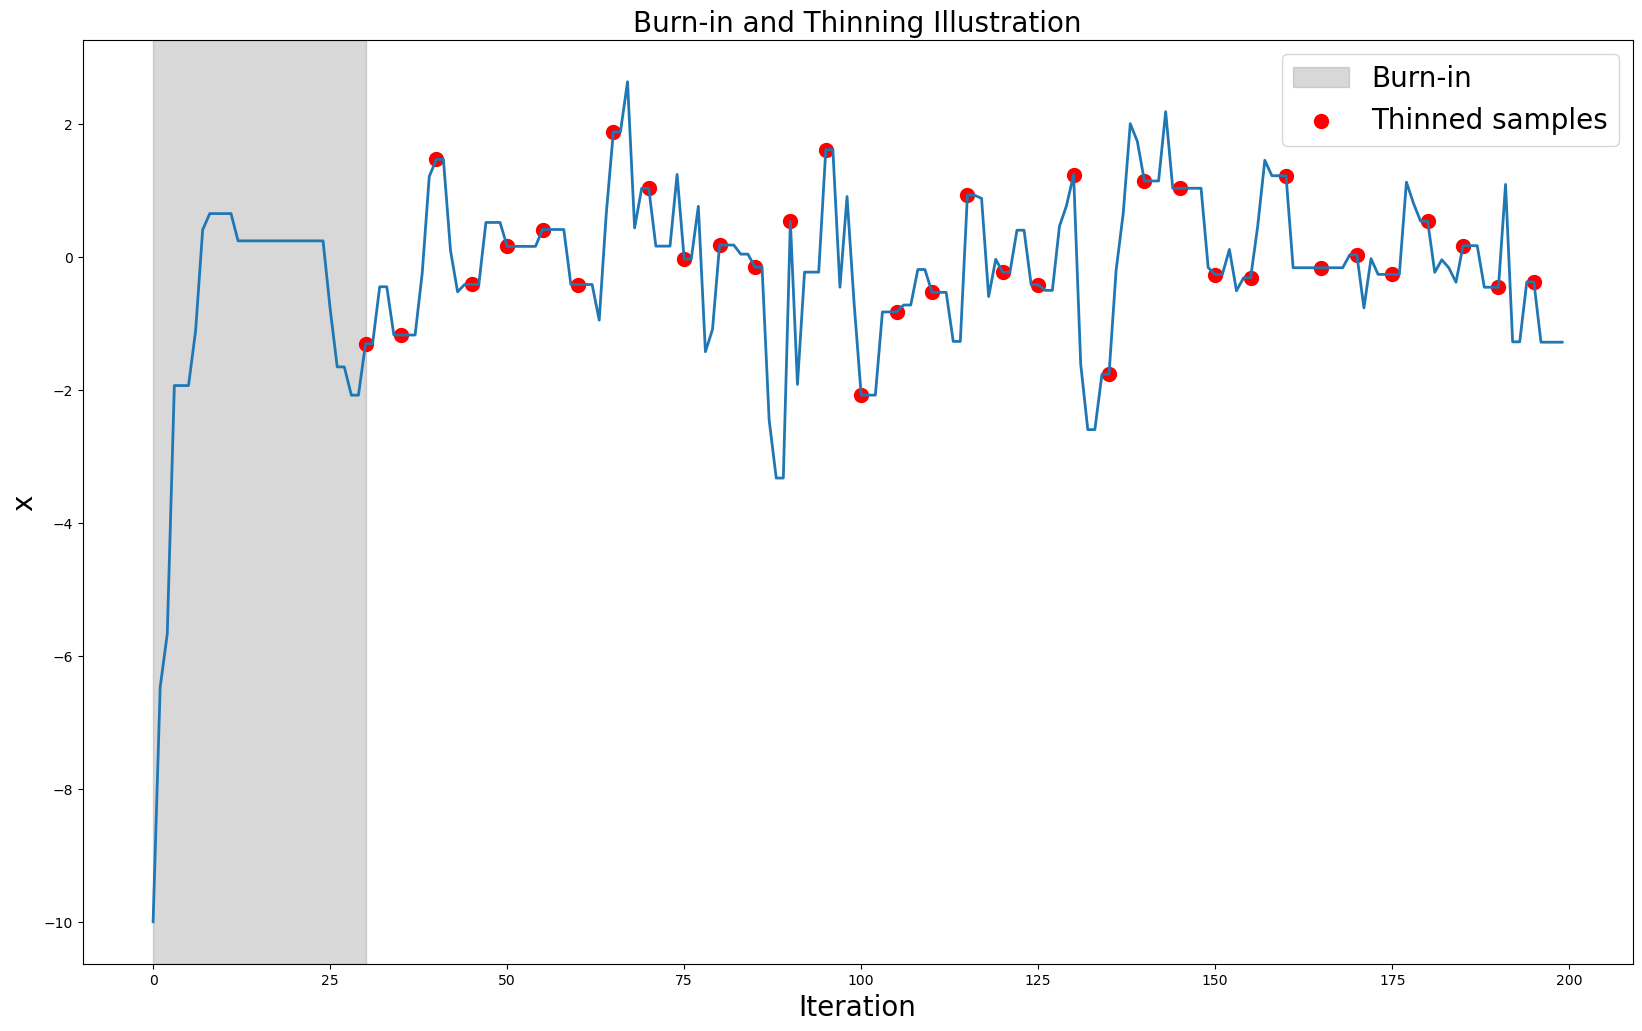

In [5]:
# simulate a single chain
np.random.seed(0)
n_steps = 200
proposal_std = 2
x = np.zeros(n_steps)
x[0] = -10

for t in range(1, n_steps):
    x[t] = metropolis_step(target_density, x[t-1], proposal_std)

# Plot
plt.figure(figsize=(20, 12))
plt.plot(x, lw=2)
plt.axvspan(0, 30, color='gray', alpha=0.3, label='Burn-in')
plt.scatter(np.arange(30, n_steps, 5), x[30::5], color='red', label='Thinned samples', s=100)
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('Burn-in and Thinning Illustration', fontsize=20)
plt.legend(fontsize=20)
plt.show()


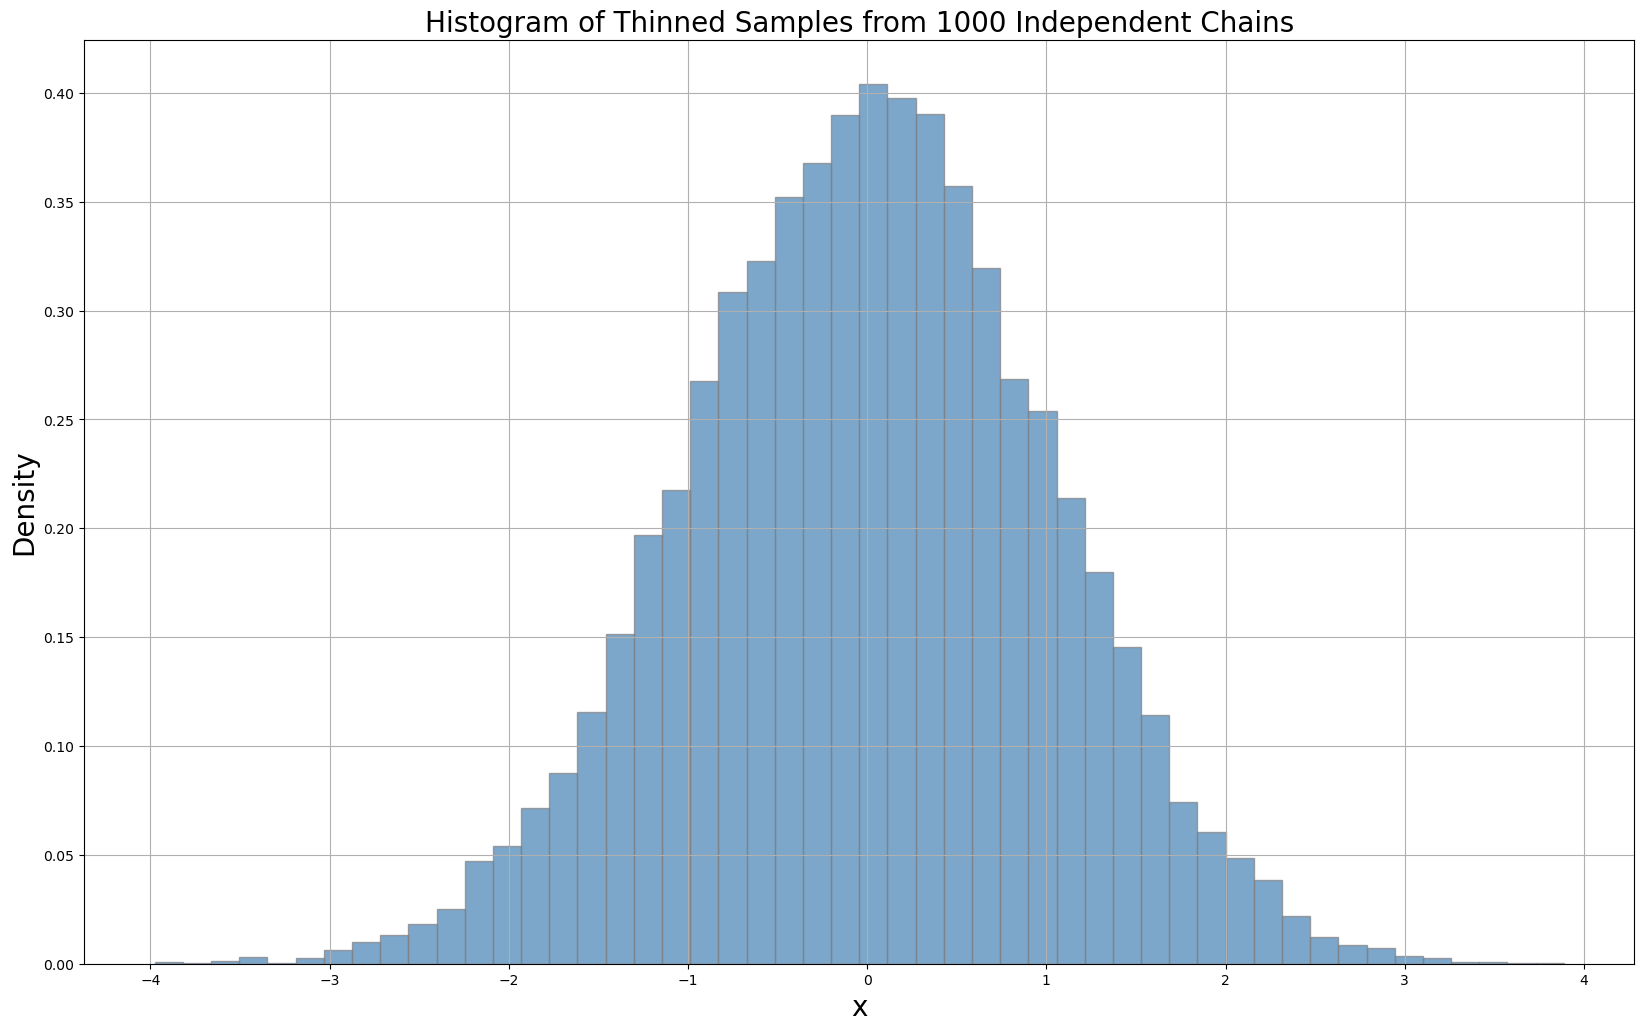

In [6]:
# simulation parameters
n_chains = 1000       # number of independent chains
n_steps = 100         # total steps per chain
burn_in = 30
thin = 5
proposal_std = 2
np.random.seed(42)
chains = np.random.uniform(-10, 10, size=n_chains)

# run chains and collect thinned samples
thinned_samples = []
for t in range(n_steps):
    for i in range(n_chains):
        chains[i] = metropolis_step(target_density, chains[i], proposal_std)
    # after burn-in, collect thinned samples
    if t >= burn_in and (t - burn_in) % thin == 0:
        thinned_samples.extend(chains.copy())

thinned_samples = np.array(thinned_samples)

# plot histogram of thinned samples
plt.figure(figsize=(20, 12))
plt.hist(thinned_samples, bins=50, density=True, color='steelblue', edgecolor='gray', alpha=0.7)
plt.xlabel('x', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.title(f'Histogram of Thinned Samples from {n_chains} Independent Chains', fontsize=20)
plt.grid(True)
plt.show()


### Comment on the Histogram

After running many independent chains, applying burn-in and thinning, the combined thinned samples form a histogram that approximates the target distribution.

The histogram shows the probability density of the target, with higher frequencies where the distribution has higher probability (near the mean, lower spread in the tails).

As the number of chains and samples increases, the histogram converges to the true Normal(0,10) density.

This demonstrates the key property of MCMC: even though individual samples are dependent and start from different points, after burn-in and with sufficient sampling, the collected samples are effectively drawn from the stationary distribution.
